# 1. Parameters

In [1]:
from pathlib import Path
from os import mkdir
import pandas as pd
import seaborn as sns

simulation_root_dir = Path('simulations')

figures_path = Path('figures')
if not figures_path.exists():
    mkdir(figures_path)
    
min_cov = 10

coverage_cases = [5, 10, 20, 30, 40, 50]
coverage_paths = [simulation_root_dir / f'cov-{x}' for x in coverage_cases]

# 2. Indexing

## 2.1. Coverage comparison

In [2]:
from typing import List

index_info_reads_paths = [x / 'reads-index-info.tsv' for x in coverage_paths]
index_info_reads_paths = [x for x in index_info_reads_paths if x.exists()]

index_info_assemblies_paths = [x / 'assemblies-index-info.tsv' for x in coverage_paths]
index_info_assemblies_paths = [x for x in index_info_assemblies_paths if x.exists()]

def read_all_df(index_paths: List[Path]) -> pd.DataFrame:
    dfs = []
    for index in index_paths:
        dfs.append(pd.read_csv(index, sep='\t'))
        
    return pd.concat(dfs).reset_index(drop=True)

index_info_df = read_all_df(index_info_reads_paths + index_info_assemblies_paths)
index_info_df['Type'] = index_info_df['Name'].str.extract(r'^cov-\d+ (\w+)')
index_info_df['Coverage'] = index_info_df['Name'].str.extract(r'^cov-(\d+)').astype(int)
index_info_df.head(5)

,Name,Iteration,Number samples,Number cores,Reference length,Analysis runtime,Analysis memory (max),Analysis memory (max/process),Analysis disk uage,Index runtime,Index memory (max),Index memory (max/process),Index size,Tree runtime,Tree memory (max),Tree memory (max/process),Total runtime,Max memory,Type,Coverage
0,cov-5 reads,1,59,32,10834,99.42,2.784723e+09,389959680.0,3.249123e+09,20.07,6.017671e+09,805515264.0,2166784.0,92.15,287158272.0,223989760.0,211.64,6.017671e+09,reads,5
1,cov-5 reads,2,59,32,10834,100.97,2.802766e+09,395599872.0,3.249127e+09,20.34,6.014718e+09,816881664.0,2170880.0,120.26,286437376.0,223916032.0,241.57,6.014718e+09,reads,5
2,cov-5 reads,3,59,32,10834,96.93,2.783080e+09,397373440.0,3.249119e+09,20.95,6.013092e+09,811298816.0,2158592.0,94.43,285200384.0,223801344.0,212.31,6.013092e+09,reads,5
3,cov-10 reads,1,59,32,10834,124.17,2.721911e+09,395726848.0,3.254985e+09,14.17,5.987484e+09,554250240.0,2695168.0,106.24,348872704.0,223760384.0,244.58,5.987484e+09,reads,10
4,cov-10 reads,2,59,32,10834,99.03,2.731401e+09,399642624.0,3.254997e+09,15.38,5.990711e+09,546975744.0,2695168.0,136.44,349233152.0,223801344.0,250.85,5.990711e+09,reads,10


### 2.1.2. Runtime plots

In [3]:
index_info_runtime_df = pd.melt(index_info_df, id_vars=['Type', 'Coverage'],
        value_vars=['Analysis runtime', 'Index runtime', 'Tree runtime'])
index_info_runtime_df = index_info_runtime_df.rename({'variable': 'Stage', 'value': 'Time (seconds)'}, axis='columns')
index_info_runtime_df['Stage'] = index_info_runtime_df['Stage'].str.replace(' runtime', '', regex=False)
index_info_runtime_df.head(6)

,Type,Coverage,Stage,Time (seconds)
0,reads,5,Analysis,99.42
1,reads,5,Analysis,100.97
2,reads,5,Analysis,96.93
3,reads,10,Analysis,124.17
4,reads,10,Analysis,99.03
5,reads,10,Analysis,104.47


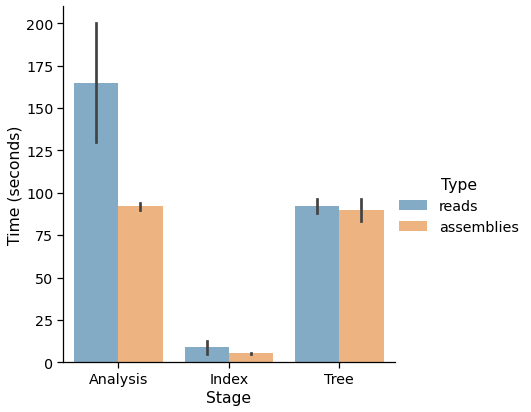

In [4]:
times_cov = index_info_runtime_df[index_info_runtime_df['Coverage'] == 50]

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(
        data=times_cov, kind="bar",
        x="Stage", y="Time (seconds)", hue="Type",
        ci="sd", alpha=.6, height=6
    )

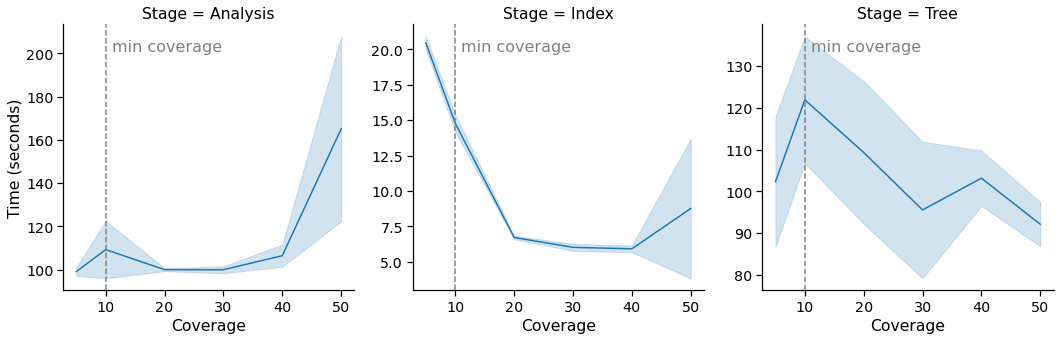

In [5]:
reads_runtime_df = index_info_runtime_df[index_info_runtime_df['Type'] == 'reads']

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Coverage', y='Time (seconds)', col="Stage", ci="sd", kind="line", data=reads_runtime_df,
                   facet_kws={'sharey': False, 'sharex': True}, col_wrap=3, height=5)
    
    for ax in g.axes.flat:
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.1
        ax.text(min_cov + 1, ypos, 'min coverage', fontdict={'size': 16, 'color': 'gray'})

### 2.1.3. Analysis memory plots

In [6]:
index_info_memory_df = pd.melt(index_info_df, id_vars=['Type', 'Coverage'],
        value_vars=['Analysis memory (max)', 'Index memory (max)', 'Tree memory (max)'])
index_info_memory_df['value'] = index_info_memory_df['value'].apply(lambda x: x/(1024**3))
index_info_memory_df = index_info_memory_df.rename({'variable': 'Stage', 'value': 'Memory (GB)'}, axis='columns')
index_info_memory_df['Stage'] = index_info_memory_df['Stage'].str.replace(' memory (max)', '', regex=False)
index_info_memory_df.head(3)

,Type,Coverage,Stage,Memory (GB)
0,reads,5,Analysis,2.593475
1,reads,5,Analysis,2.610279
2,reads,5,Analysis,2.591946


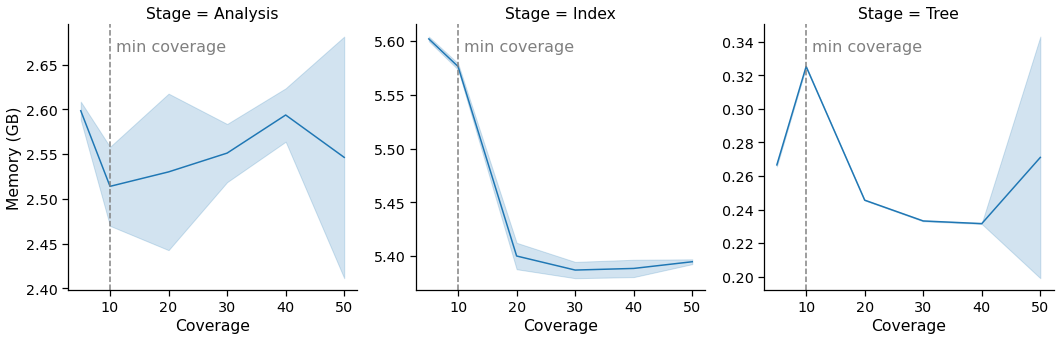

In [7]:
reads_memory_df = index_info_memory_df[index_info_memory_df['Type'] == 'reads']

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Coverage', y='Memory (GB)', col="Stage", ci="sd", kind="line", data=reads_memory_df,
                   facet_kws={'sharey': False, 'sharex': True}, col_wrap=3, height=5)
    
    for ax in g.axes.flat:
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.1
        ax.text(min_cov + 1, ypos, 'min coverage', fontdict={'size': 16, 'color': 'gray'})

### 2.1.3. Disk usage plots

In [8]:
index_info_disk_df = pd.melt(index_info_df, id_vars=['Type', 'Coverage'],
        value_vars=['Analysis disk uage', 'Index size'])
index_info_disk_df['value'] = index_info_disk_df['value'].apply(lambda x: x/(1024**3))
index_info_disk_df = index_info_disk_df.rename({'variable': 'Stage', 'value': 'Disk (GB)'}, axis='columns')
index_info_disk_df['Stage'] = index_info_disk_df['Stage'].str.replace(' disk uage', '', regex=False)
index_info_disk_df['Stage'] = index_info_disk_df['Stage'].str.replace(' size', '', regex=False)
index_info_disk_df.head(3)

,Type,Coverage,Stage,Disk (GB)
0,reads,5,Analysis,3.025982
1,reads,5,Analysis,3.025986
2,reads,5,Analysis,3.025978


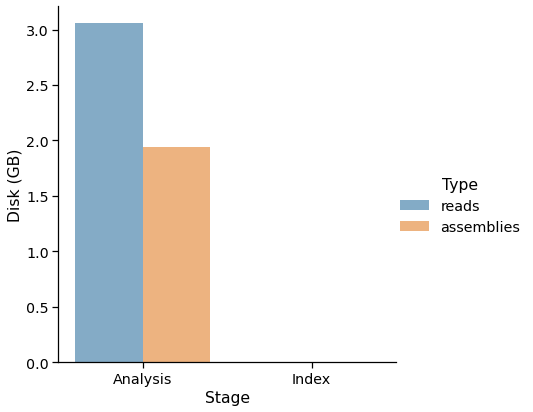

In [9]:
disk_cov = index_info_disk_df[index_info_disk_df['Coverage'] == 50]

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(
        data=disk_cov, kind="bar",
        x="Stage", y="Disk (GB)", hue="Type",
        ci="sd", alpha=.6, height=6,
    )

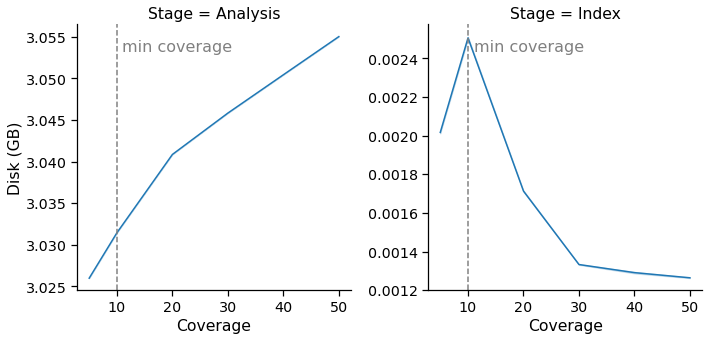

In [10]:
reads_disk_df = index_info_disk_df[index_info_disk_df['Type'] == 'reads']

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Coverage', y='Disk (GB)', col="Stage", ci="sd", kind="line", data=reads_disk_df,
                   facet_kws={'sharey': False, 'sharex': True}, col_wrap=3, height=5)
    
    for ax in g.axes.flat:
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.1
        ax.text(min_cov + 1, ypos, 'min coverage', fontdict={'size': 16, 'color': 'gray'})

# 3. Querying

In [11]:
query_paths = [x / 'query-reads-api.tsv' for x in coverage_paths]
query_paths = [x for x in query_paths if x.exists()]


query_df = read_all_df(query_paths)
query_df['Type'] = query_df['Name'].str.extract(r'^cov-\d+ \((\w+)\)')
query_df['Coverage'] = query_df['Name'].str.extract(r'^cov-(\d+)').astype(int)
query_df['Time'] = query_df['Time'].apply(lambda x: x * 1000)
query_df = query_df.rename({'Time': 'Time (ms)'}, axis='columns')
query_df.head(5)

,Name,Kind,Number features,Iteration,Time (ms),Type,Coverage
0,cov-5 (reads),features_summary,159,1,17.304381,reads,5
1,cov-5 (reads),features_summary,159,2,17.266489,reads,5
2,cov-5 (reads),features_summary,159,3,17.226916,reads,5
3,cov-5 (reads),features_summary,159,4,17.218661,reads,5
4,cov-5 (reads),features_summary,159,5,17.123637,reads,5


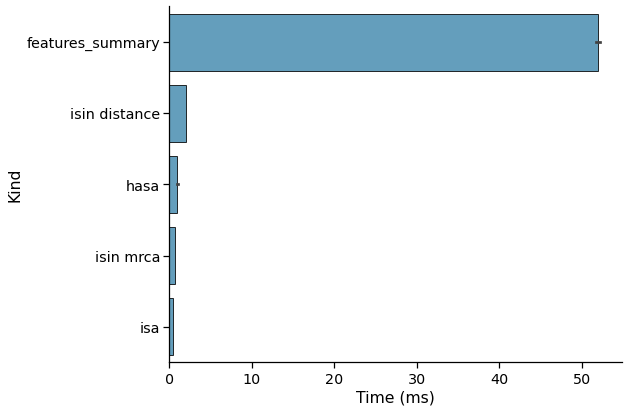

In [12]:
query_cov = query_df[query_df['Coverage'] == 50]
query_cov = query_cov.sort_values('Time (ms)', ascending=False)

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(
        data=query_cov, kind="bar",
        y="Kind", x="Time (ms)", hue=None,
        ci="sd", height=6, aspect=1.5, alpha=0.8, color="#2b8cbe", edgecolor="black"
    )

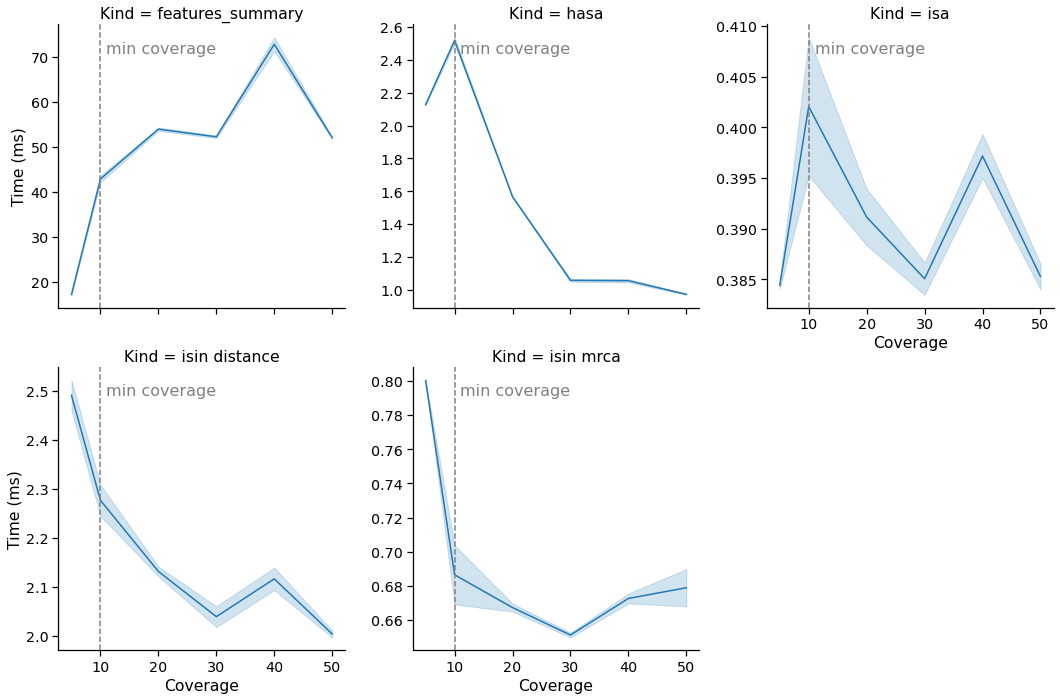

In [13]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Coverage', y='Time (ms)', col="Kind", ci="sd", kind="line", data=query_df,
                   facet_kws={'sharey': False, 'sharex': True}, col_wrap=3, height=5)
    
    for ax in g.axes.flat:
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.1
        ax.text(min_cov + 1, ypos, 'min coverage', fontdict={'size': 16, 'color': 'gray'})

# 4. Features comparison

In [41]:
features_paths = [x / 'variants-comparison.tsv' for x in coverage_paths]
features_paths = [x for x in features_paths if x.exists()]

features_df = read_all_df(features_paths)
features_df
features_df['Type'] = features_df['Name'].str.extract(r'^cov-\d+ (\w+)')
features_df['Coverage'] = features_df['Name'].str.extract(r'^cov-(\d+)').astype(int)

features_count_df = pd.melt(features_df, id_vars=['Type', 'Coverage'],
        value_vars=['True Positives', 'False Positives', 'False Negatives'])
features_count_df = features_count_df.rename({'value': 'Count'}, axis='columns')

features_score_df = pd.melt(features_df, id_vars=['Type', 'Coverage'],
                            value_vars=['Sensitivity', 'Precision', 'F1 Score'])
features_score_df = features_score_df.rename({'value': 'Score'}, axis='columns')
features_count_df.head(3)

,Type,Coverage,variable,Count
0,reads,5,True Positives,244
1,assemblies,5,True Positives,10026
2,reads,10,True Positives,3831


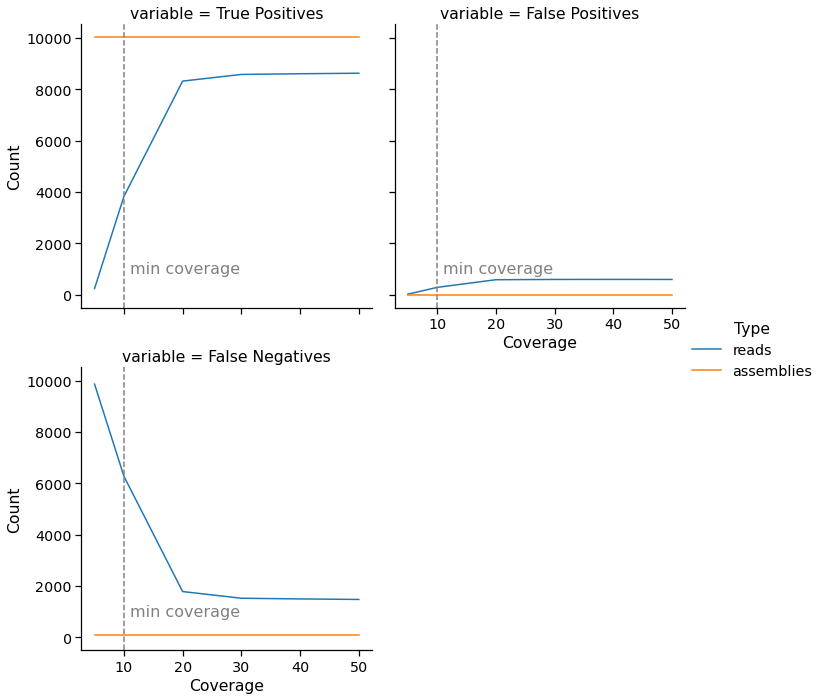

In [48]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Coverage', y='Count', hue="Type", ci="sd", kind="line", col="variable",
                    data=features_count_df,
                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=2, height=5,
                   )
    
    for ax in g.axes.flat:
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[0] + ylen * 0.12
        ax.text(min_cov + 1, ypos, 'min coverage', fontdict={'size': 16, 'color': 'gray'})

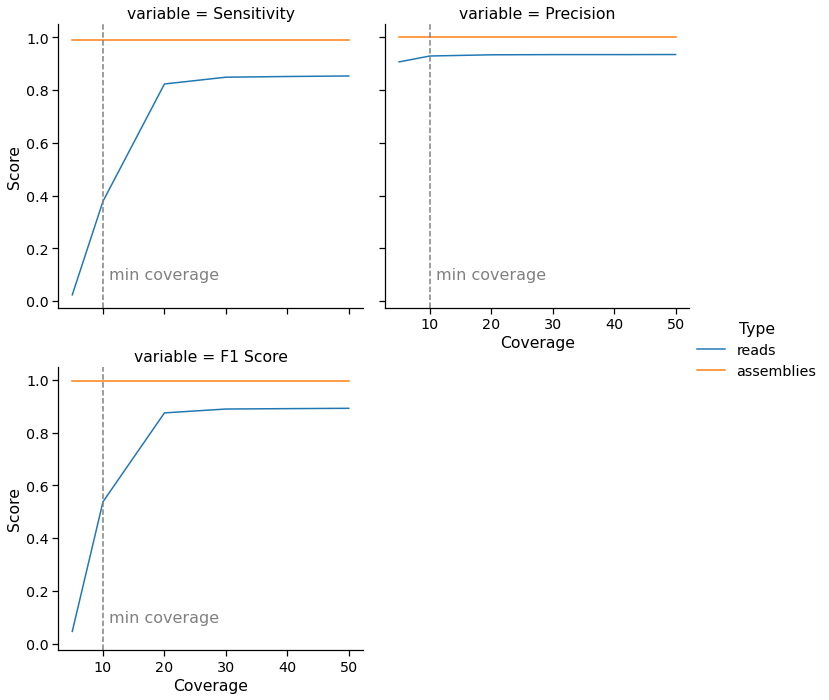

In [46]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Coverage', y='Score', hue="Type", ci="sd", kind="line", col="variable",
                    data=features_score_df,
                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=2, height=5,
                   )
    
    for ax in g.axes.flat:
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[0] + ylen * 0.1
        ax.text(min_cov + 1, ypos, 'min coverage', fontdict={'size': 16, 'color': 'gray'})

# 5. Compare trees

## 5.1. Loading trees

In [54]:
trees_file = simulation_root_dir / 'tree-comparisons.tsv'

trees_df = pd.read_csv(trees_file, sep='\t')
trees_df = pd.melt(trees_df, id_vars=['Types', 'Coverage'],
        value_vars=['RF_Distance', 'KC_Distance']).rename({'variable': 'Measure', 'value': 'Distance'}, 
                                                          axis='columns')
trees_df['Measure'] = trees_df['Measure'].str.replace('RF_Distance', 'Robinson-Foulds')
trees_df['Measure'] = trees_df['Measure'].str.replace('KC_Distance', 'Kendall-Colijn')
trees_df

,Types,Coverage,Measure,Distance
0,reads,5,Robinson-Foulds,112.000000
1,reads,10,Robinson-Foulds,84.000000
2,reads,20,Robinson-Foulds,78.000000
3,reads,30,Robinson-Foulds,90.000000
4,reads,40,Robinson-Foulds,88.000000
5,reads,50,Robinson-Foulds,90.000000
6,assembly,5,Robinson-Foulds,78.000000
7,assembly,10,Robinson-Foulds,82.000000
8,assembly,20,Robinson-Foulds,84.000000
9,assembly,30,Robinson-Foulds,82.000000


## 5.1. Compare reads vs. assembly

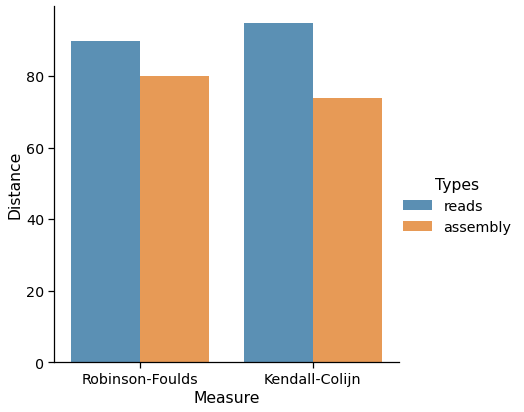

In [56]:
trees_cov = trees_df[trees_df['Coverage'] == 50]

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(
        data=trees_cov, kind="bar",
        x="Measure", y="Distance", hue="Types",
        ci="sd", alpha=.8, height=6,
    )

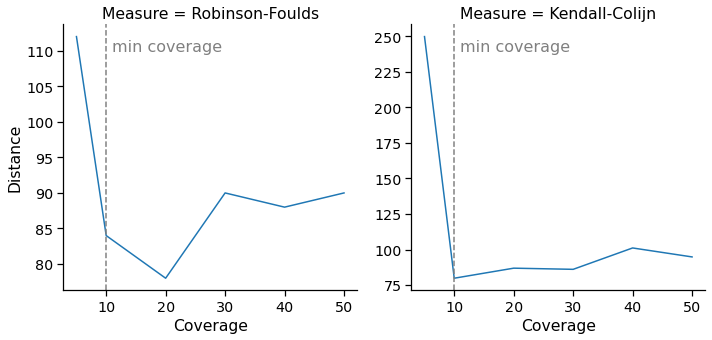

In [58]:
trees_reads_df = trees_df[trees_df['Types'] == 'reads']

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Coverage', y='Distance', col="Measure", ci="sd", kind="line", data=trees_reads_df,
                   facet_kws={'sharey': False, 'sharex': True}, col_wrap=3, height=5)
    
    for ax in g.axes.flat:
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.1
        ax.text(min_cov + 1, ypos, 'min coverage', fontdict={'size': 16, 'color': 'gray'})